

#Random Forest - Predicción de ImpactPlayerScore en CS:GO y Clasificacion de jugadores por impacto -  HighImpactPlayer




##Modelo de regresion -- Se puede determinar si un jugador tiene un alto impacto en la partida -- ImpactPlayerScore

/tmp/ipython-input-6-4218065455.py:10: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=';')


Modelo: RandomForest
MAE: 0.27
MSE: 0.23
RMSE: 0.48
R²: 0.877


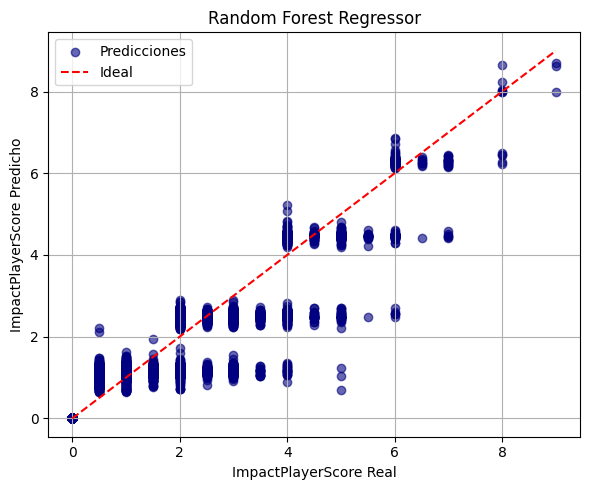

In [ ]:




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Cargar datos
url = "https://raw.githubusercontent.com/Seba-RiveraC/Crisp_DM_CSGO/refs/heads/master/Anexo%20ET_demo_round_traces_2022%20(1).csv"
df = pd.read_csv(url, sep=';')

# Crear variables
df['ImpactPlayerScore'] = df['RoundKills'] + 0.5 * df['RoundAssists'] + df['RoundHeadshots']
df['KAST'] = ((df['RoundKills'] > 0) | (df['RoundAssists'] > 0)).astype(int)

# Convertir strings numéricos
def convertir_a_float(valor):
    if isinstance(valor, str):
        valor = valor.replace('.', '').replace(',', '.')
        try:
            return float(valor)
        except:
            return np.nan
    return valor

# Aplicar conversión
for col in ['TimeAlive', 'TravelledDistance', 'KAST', 'RoundHeadshots', 'ImpactPlayerScore']:
    df[col] = df[col].apply(convertir_a_float)

# Eliminar nulos
df.dropna(subset=['TimeAlive', 'TravelledDistance', 'KAST', 'RoundHeadshots', 'ImpactPlayerScore'], inplace=True)

# Definir variables predictoras (todas disponibles y útiles)
X = df[['KAST', 'TimeAlive', 'TravelledDistance', 'RoundHeadshots']]
y = df['ImpactPlayerScore']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Modelo
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Modelo: RandomForest")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Visualización
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='navy', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("ImpactPlayerScore Real")
plt.ylabel("ImpactPlayerScore Predicho")
plt.title("Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



##Modelo de Clasificacion -- Se puede determinar cuales jugadores tuvieron un alto impacto en la partida -- HighImpactPlayerScore


/tmp/ipython-input-8-2136996135.py:11: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=';')


 Modelo: Random Forest (con hiperparámetros optimizados)
Mejores parámetros: {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 150}
Accuracy  (exactitud global):     0.770
Precision (de los positivos predichos, cuántos son correctos): 0.577
Recall    (de los positivos reales, cuántos fueron detectados): 0.874
F1 Score  (balance entre precision y recall): 0.695
AUC       (área bajo curva ROC): 0.851

Matriz de confusión:
[[4522 1712]
 [ 336 2336]]


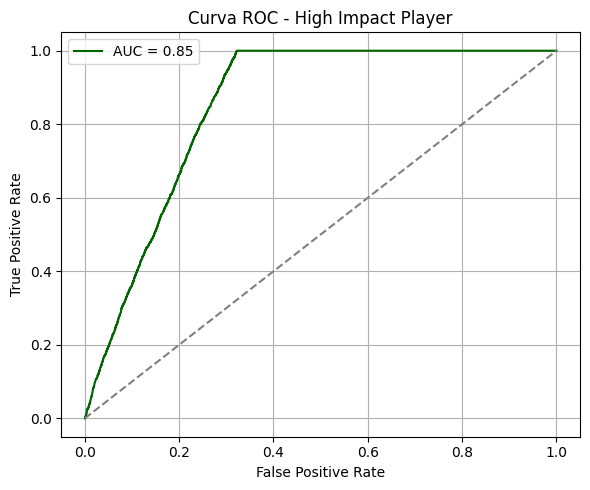

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Cargar datos
url = "https://raw.githubusercontent.com/Seba-RiveraC/Crisp_DM_CSGO/master/Anexo%20ET_demo_round_traces_2022%20(1).csv"
df = pd.read_csv(url, sep=';')

# Crear variables
df['ImpactPlayerScore'] = df['RoundKills'] + 0.5 * df['RoundAssists'] + df['RoundHeadshots']
df['KAST'] = ((df['RoundKills'] > 0) | (df['RoundAssists'] > 0)).astype(int)
df = df.sample(frac=0.45, random_state=42)

def convertir_a_float(valor):
    if isinstance(valor, str):
        valor = valor.replace('.', '').replace(',', '.')
        try:
            return float(valor)
        except:
            return np.nan
    return valor

for col in ['TimeAlive', 'TravelledDistance', 'KAST', 'ImpactPlayerScore']:
    df[col] = df[col].apply(convertir_a_float)

df.dropna(subset=['TimeAlive', 'TravelledDistance', 'KAST', 'ImpactPlayerScore'], inplace=True)

# Variable objetivo binaria
umbral = df['ImpactPlayerScore'].quantile(0.75)
df['HighImpactPlayer'] = (df['ImpactPlayerScore'] >= umbral).astype(int)

# Variables predictoras
X = df[['KAST', 'TimeAlive', 'TravelledDistance']]
y = df['HighImpactPlayer']

# División y escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 4],
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)

# Evaluación
print(" Modelo: Random Forest (con hiperparámetros optimizados)")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Accuracy  (exactitud global):     {accuracy:.3f}")
print(f"Precision (de los positivos predichos, cuántos son correctos): {precision:.3f}")
print(f"Recall    (de los positivos reales, cuántos fueron detectados): {recall:.3f}")
print(f"F1 Score  (balance entre precision y recall): {f1:.3f}")
print(f"AUC       (área bajo curva ROC): {auc_score:.3f}")
print("\nMatriz de confusión:")
print(cm)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - High Impact Player")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
